In [1]:
import pandas as pd
import numpy as np
import orbit
import matplotlib.pyplot as plt

from orbit.utils.dataset import load_iclaims
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components, params_comparison_boxplot
from orbit.utils.plot import get_orbit_style
plt.style.use(get_orbit_style())
from orbit.models import ETS

In [2]:
orbit.__version__

'1.1.3dev'

In [3]:
%load_ext autoreload
%autoreload 2

## Data

In [4]:
# can also consider transform=False
raw_df = load_iclaims(transform=True)
raw_df.dtypes

week              datetime64[ns]
claims                   float64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
sp500                    float64
vix                      float64
dtype: object

In [5]:
df = raw_df.copy()

In [6]:
df.head()

,week,claims,trend.unemploy,trend.filling,trend.job,sp500,vix
0,2010-01-03,13.386595,0.219882,-0.318452,0.117500,-0.417633,0.122654
1,2010-01-10,13.624218,0.219882,-0.194838,0.168794,-0.425480,0.110445
2,2010-01-17,13.398741,0.236143,-0.292477,0.117500,-0.465229,0.532339
3,2010-01-24,13.137549,0.203353,-0.194838,0.106918,-0.481751,0.428645
4,2010-01-31,13.196760,0.134360,-0.242466,0.074483,-0.488929,0.487404


In [13]:
test_size=52

train_df=df[:-test_size]
test_df=df[-test_size:]

In [23]:
ets = ETS(response_col='claims',
          date_col='week',
          seasonality=52,
          seed=2020,
          estimator='numpyro-map',
          n_iters=1000,
          # num_samples=3000,
          # num_warmups=1000,
)
ets.fit(train_df)

/Users/towinazure/opt/miniconda3/envs/orbit38/lib/python3.8/site-packages/numpyro/contrib/control_flow/scan.py:264: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  length = tree_flatten(xs)[0][0].shape[0]
/Users/towinazure/opt/miniconda3/envs/orbit38/lib/python3.8/site-packages/numpyro/contrib/control_flow/scan.py:264: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  length = tree_flatten(xs)[0][0].shape[0]
/Users/towinazure/opt/miniconda3/envs/orbit38/lib/python3.8/site-packages/numpyro/contrib/control_flow/scan.py:264: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  length = tree_flatten(xs)[0][0].shape[0]
100%|████████████████████████| 1000/1000 [00:00<00:00, 1430.78it/s, init loss: 724.8259, avg. loss [951-1000]: -516.2739]


In [24]:
predicted_df = ets.predict(df=df, decompose=True)
predicted_df

,week,prediction,trend,seasonality
0,2010-01-03,13.386595,13.289471,0.097124
1,2010-01-10,13.303627,13.404680,-0.101053
2,2010-01-17,13.517189,13.362115,0.155074
3,2010-01-24,13.245330,13.323382,-0.078052
4,2010-01-31,13.194467,13.324206,-0.129740
...,...,...,...,...
438,2018-05-27,12.293335,12.377140,-0.083805
439,2018-06-03,12.315749,12.377140,-0.061391
440,2018-06-10,12.355524,12.377140,-0.021615
441,2018-06-17,12.348784,12.377140,-0.028356


In [25]:
numpyro_ps = ets.get_posterior_samples()

In [50]:
ets = ETS(response_col='claims',
          date_col='week',
          seasonality=52,
          seed=2020,
          estimator='stan-mcmc',
          num_samples=3000,
          num_warmups=1000,
)
ets.fit(train_df)

INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [51]:
predicted_df = ets.predict(df=df, decompose=True)
predicted_df

,week,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95
0,2010-01-03,13.261310,13.386944,13.513031,12.901224,13.050523,13.168414,0.286928,0.334000,0.377123
1,2010-01-10,13.491724,13.611873,13.725977,12.948396,13.054659,13.155576,0.468950,0.560748,0.645295
2,2010-01-17,13.239785,13.383245,13.554428,12.945309,13.060593,13.175308,0.217786,0.319816,0.412414
3,2010-01-24,12.965324,13.146989,13.262713,12.916679,13.059871,13.168505,0.001057,0.080590,0.175384
4,2010-01-31,13.006539,13.182529,13.322530,12.938332,13.068877,13.166903,0.009972,0.110139,0.236061
...,...,...,...,...,...,...,...,...,...,...
438,2018-05-27,12.125931,12.349255,12.547320,12.228475,12.447617,12.650722,-0.110265,-0.098350,-0.082460
439,2018-06-03,12.077620,12.278935,12.466311,12.243003,12.446729,12.627049,-0.180056,-0.165039,-0.147178
440,2018-06-10,12.175883,12.370888,12.554804,12.241413,12.435736,12.621857,-0.079085,-0.065936,-0.048196
441,2018-06-17,12.158958,12.330557,12.543217,12.266208,12.425400,12.644227,-0.108878,-0.095862,-0.075859


In [52]:
stan_ps.keys()

odict_keys(['l', 'lev_sm', 'obs_sigma', 's', 'sea_sm'])

In [53]:
stan_ps = ets.get_posterior_samples()

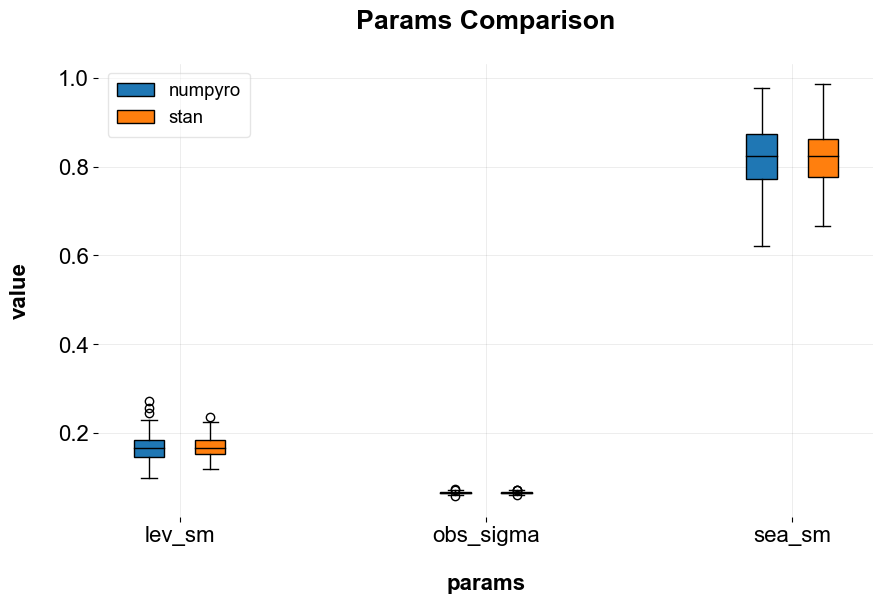

In [54]:
params_comparison_boxplot(
        [numpyro_ps, stan_ps],
        var_names=['lev_sm', 'obs_sigma', 'sea_sm'],
        model_names=["numpyro", "stan"],
        box_width = .1, box_distance=0.1,
        showfliers=True
);

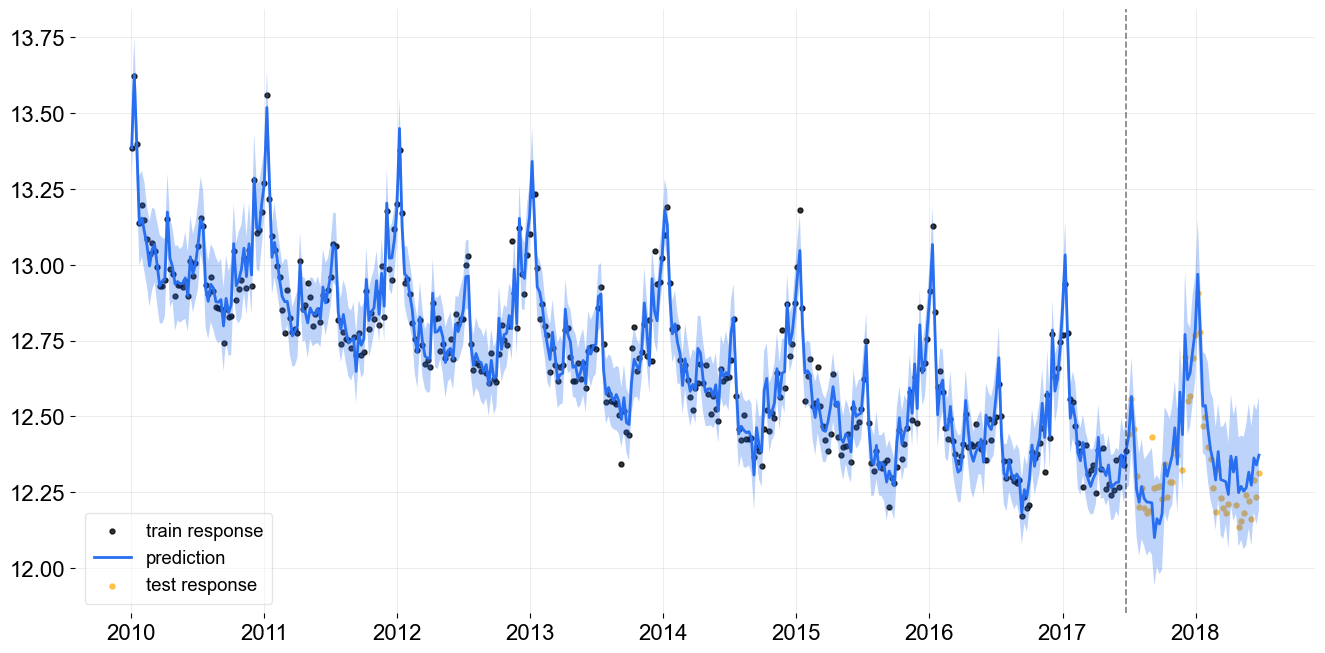

In [31]:
_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df,
                        date_col='week',
                        actual_col='claims',
                        test_actual_df=test_df)

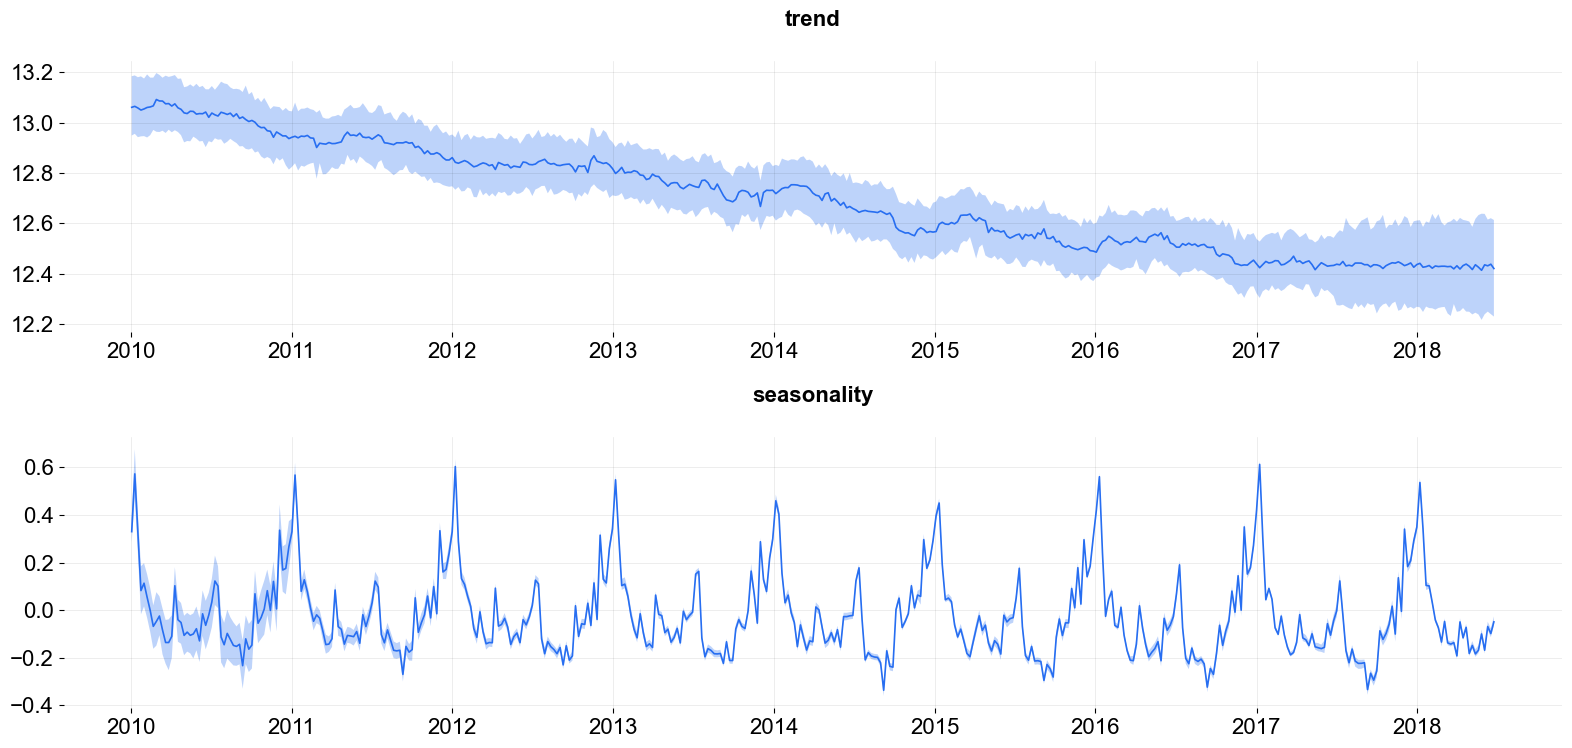

In [32]:
_ = plot_predicted_components(predicted_df=predicted_df, date_col='week')